In [1]:
#Imports
import cv2
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d,art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib notebook

In [2]:
#Load the solution values of task1a
pnparg = np.load("data/pnparg.npz")
sol_1a = np.load("data/sol_1a.npz")
cameraMatrix = pnparg['cameraMatrix']
image_plane_center = pnparg['image_plane_center_zero']
camera_center_matrix=np.zeros((8,3))
r_vec_matrix=np.zeros((8,9))
t_vec_matrix=np.zeros((8,3))
rvec_matrix=sol_1a["rvec"]
tvec_matrix=sol_1a["tvec"]
camera_center_matrix=sol_1a["camera_center"]

In [3]:
#Set the image path
cwd = os.getcwd()
image_path=os.path.join(cwd,"task1/init_texture")
image_list=os.listdir(image_path)
image_list_path=[os.path.join(image_path,x) for x in image_list]


if not os.path.exists('sol_1b'):
    os.makedirs('sol_1b')
if not os.path.exists('sol_1b/2dpoints_backpro'):
    os.makedirs('sol_1b/2dpoints_backpro')
if not os.path.exists('sol_1b/2dpoints_sift'):
    os.makedirs('sol_1b/2dpoints_sift')    
if not os.path.exists('sol_1b/3d_sift'):
    os.makedirs('sol_1b/3d_sift')        

In [4]:
#Adapted from https://www.scratchapixel.com/lessons..
#/3d-basic-rendering/minimal-ray-tracer-rendering-simple-shapes/ray-box-intersection

#Algorithm to find the intersection of the ray with the box

def ray_box_intersection(intercept,ray_direction):
    #Function to find the intersection and the distance measure
    flag= 1
    mincoordinates=np.array([0,0,0]).reshape(3,1)
    maxcoordinates=np.array([0.165,0.063,0.093]).reshape(3,1)
    
    tmin=(mincoordinates[0]-intercept[0])/ray_direction[0]
    tmax=(maxcoordinates[0]-intercept[0])/ray_direction[0]
    
    if (tmin>tmax):
        tmax,tmin=tmin,tmax

    tymin=(mincoordinates[1]-intercept[1])/ray_direction[1]    
    tymax=(maxcoordinates[1]-intercept[1])/ray_direction[1]    
    
    if (tymin>tymax):
        tymax,tymin=tymin,tymax
        
    if ((tmin > tymax) or (tymin > tmax)) :
        flag=0
        
    if (tymin > tmin): 
        tmin = tymin

    if (tymax < tmax) :
        tmax = tymax

    tzmin=(mincoordinates[2]-intercept[2])/ray_direction[2]    
    tzmax=(maxcoordinates[2]-intercept[2])/ray_direction[2]    
    
    if (tzmin > tzmax):
        tzmax,tzmin=tzmin,tzmax
        
    if ((tmin > tzmax) or (tzmin > tmax)):
        flag=0
        
    if (tzmin > tmin): 
        tmin = tzmin
        
    if (tzmax < tmax): 
        tmax = tzmax   
        
    if(tmin>tmax):
        tmin,tmax=tmax,tmin
    return flag,tmin    

In [5]:
#Returns all the SIFT keypoints and the descriptors in the entire image
def all_sift_points(image_list_path,idx):
    
    img = cv2.imread(image_list_path[idx+1])
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    (kp, des) = sift.detectAndCompute(gray, None)
    img_kp=None
    img_kp=cv2.drawKeypoints(gray,kp,img_kp)
    sift_image_name="1b/2dsift_all/"+"image"+str(idx)+".jpg"
    cv2.imwrite(sift_image_name,img_kp)
    return kp,des

In [6]:
#Function that returns the list of all SIFT keypoints in 3D ,2D and the descriptors belonging 
#to the box

def box_sift_points(kp,des,idx):
    kp_box=[]
    kp_point_box=[]
    kp_rescaled_box=[]
    kp_3d=[]
    des_box=[]
    
    for i in range(len(kp)):
        flag=1
        kp_point=kp[i]
        des_point=des[i]
        intercept = camera_center_matrix[idx,:].reshape(3, 1)
        rvec=rvec_matrix[idx,:].reshape(3, 3)
        tvec=tvec_matrix[idx,:].reshape(3, 1)
        kp_pt_rescaled = np.array([kp_point.pt[0]-image_plane_center[idx][0], kp_point.pt[1]-image_plane_center[idx][1], 1]).reshape(3, 1)
        ray_direction = np.matmul(np.linalg.inv(np.matmul(cameraMatrix, rvec)), kp_pt_rescaled)
        flag,tmin = ray_box_intersection(intercept, ray_direction)
        if(flag==1):
            kp_box.append(kp_point)
            kp_point_box.append(kp_point.pt)
            kp_rescaled_box.append(kp_pt_rescaled)
            kp_3d_point = intercept+tmin*ray_direction
            kp_3d.append(kp_3d_point)
            des_box.append(des_point)
            
    return kp_box,kp_point_box,kp_rescaled_box,kp_3d,des_box
        


In [7]:
#Runs the above funtion for all the images and stores it all together as a list for all images

kp_all_images=[]
kp_point_all_images=[]
kp_rescaled_all_images=[]
kp_3d_all_images=[]
des_all_images=[]


for ii in range(8):
    print("Calculating Image ",ii)
    kp,des=all_sift_points(image_list_path,ii)
    
    kp_box,kp_point_box,kp_rescaled_box,kp_3d,des_box=box_sift_points(kp,des,ii)
    
    kp_all_images.append(kp_box)
    kp_point_all_images.append(kp_point_box)
    kp_rescaled_all_images.append(kp_rescaled_box)
    kp_3d_all_images.append(kp_3d)
    des_all_images.append(des_box)

Calculating Image  0
Calculating Image  1
Calculating Image  2
Calculating Image  3
Calculating Image  4
Calculating Image  5
Calculating Image  6
Calculating Image  7


In [8]:
#Visualise the filtered sift points directly from opencv drawkeypoints
def sift_plot_2D_v1(idx,kp_all_images):
    img = cv2.imread(image_list_path[idx+1])
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_kp=None
    kp=kp_all_images[idx]
    img_kp=cv2.drawKeypoints(gray,kp,img_kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    sift_image_name="sol_1b/2dpoints_sift/"+"image"+str(idx)+".jpg"
    cv2.imwrite(sift_image_name,img_kp)
  
    
for ii in range(8):
    print("Plotting Image ",ii)
    sift_plot_2D_v1(ii,kp_all_images)   

Plotting Image  0
Plotting Image  1
Plotting Image  2
Plotting Image  3
Plotting Image  4
Plotting Image  5
Plotting Image  6
Plotting Image  7


Plotting Image  0


<IPython.core.display.Javascript object>


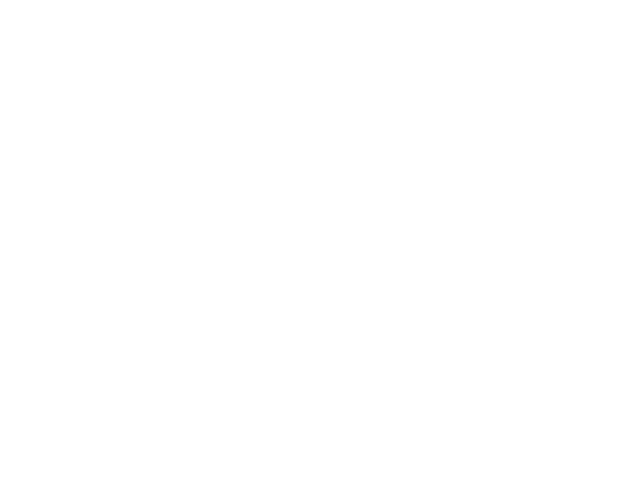

Plotting Image  1


<IPython.core.display.Javascript object>


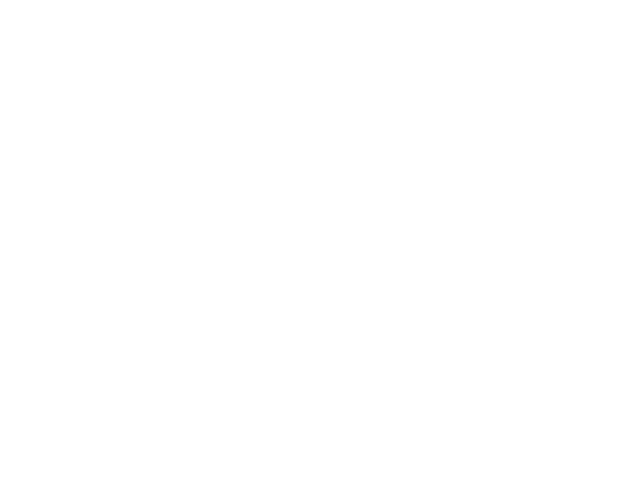

Plotting Image  2


<IPython.core.display.Javascript object>


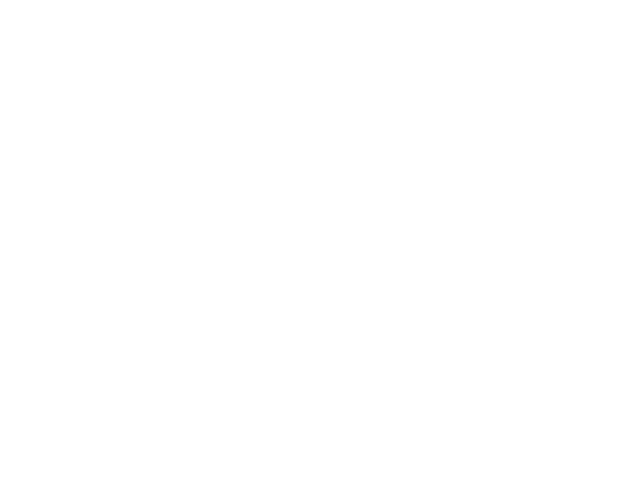

Plotting Image  3


<IPython.core.display.Javascript object>


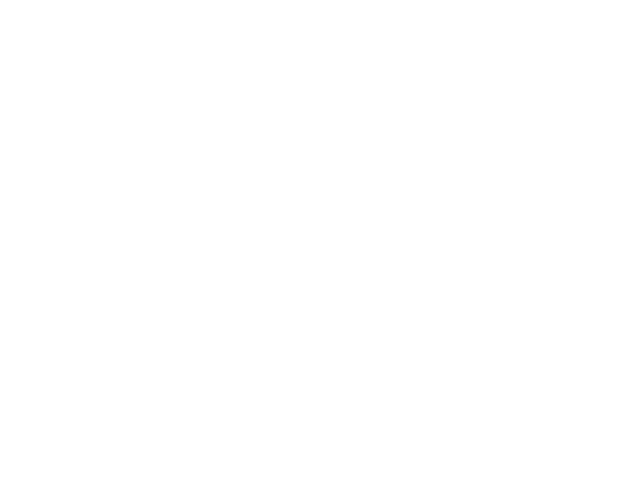

Plotting Image  4


<IPython.core.display.Javascript object>


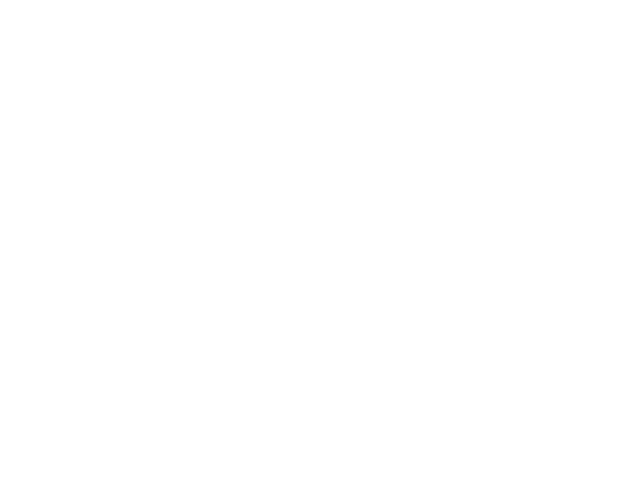

Plotting Image  5


<IPython.core.display.Javascript object>


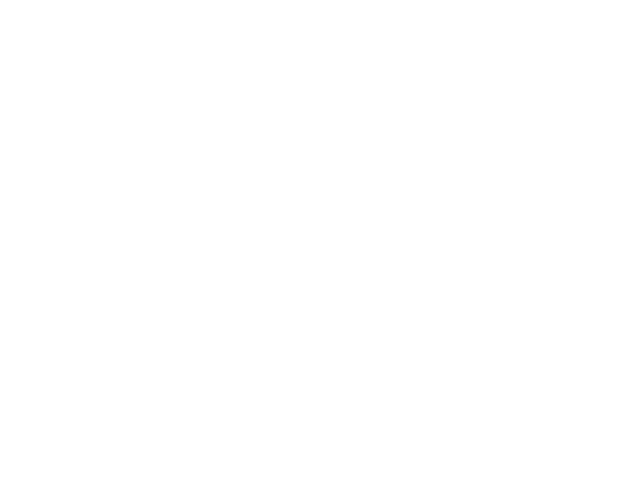

Plotting Image  6


<IPython.core.display.Javascript object>


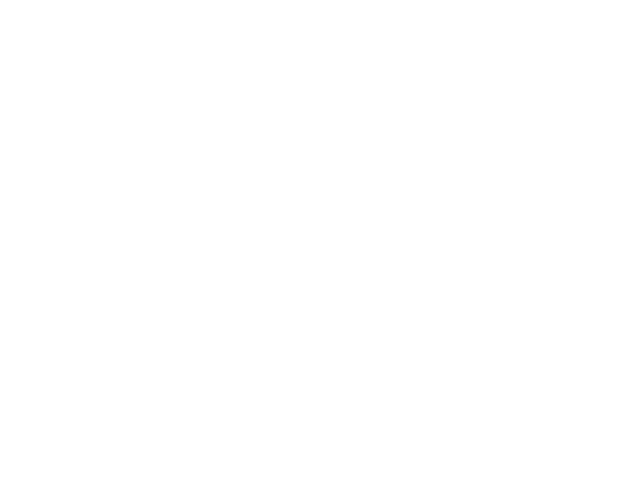

Plotting Image  7


<IPython.core.display.Javascript object>


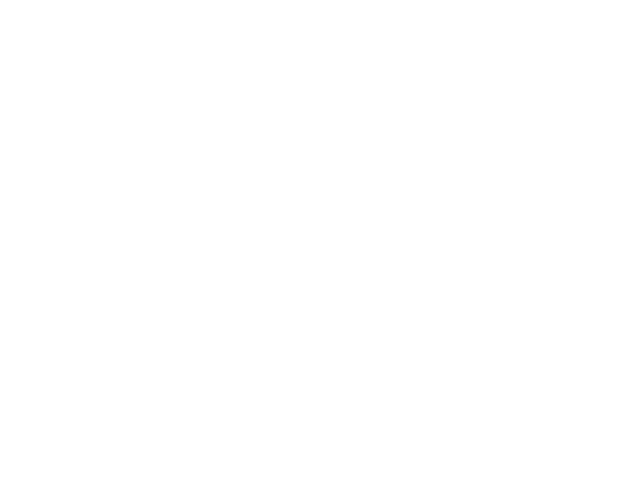

In [9]:
#Visualise the filtered sift points by backprojecting from 3D coordinates provided by ray-box intersection method
def sift_plot_2D_v2(idx,kp_3d_all_images):
    img = cv2.imread(image_list_path[idx+1])
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    rvec=rvec_matrix[idx,:].reshape(3, 3)
    tvec=tvec_matrix[idx,:].reshape(3, 1)
    
    implot = plt.imshow(gray,cmap='gray')
    kp_3d_image=kp_3d_all_images[idx]
    for i_point in kp_3d_image:
        px=np.matmul(cameraMatrix,np.matmul(rvec,i_point)+tvec)
        ux=px[0]/px[2]+image_plane_center[idx][0]
        uy=px[1]/px[2]+image_plane_center[idx][1]
        plt.scatter(x=ux, y=uy, c='r', s=0.2)
   
    image_name="sol_1b/2dpoints_backpro/"+"image"+str(idx)+".jpg"
    plt.axis('off')
    plt.savefig(image_name,bbox_inches = 'tight',pad_inches = 0)
    plt.close('all')
        
for idx in range(8):
    print("Plotting Image ",idx)
    sift_plot_2D_v2(idx,kp_3d_all_images)       

Plotting Image  0


<IPython.core.display.Javascript object>


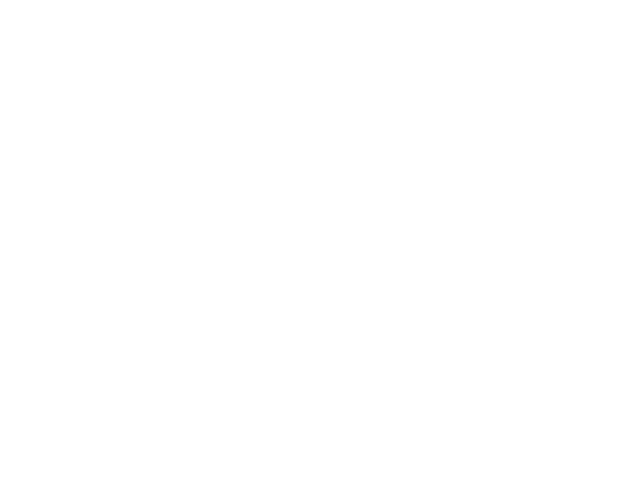

Plotting Image  1


<IPython.core.display.Javascript object>


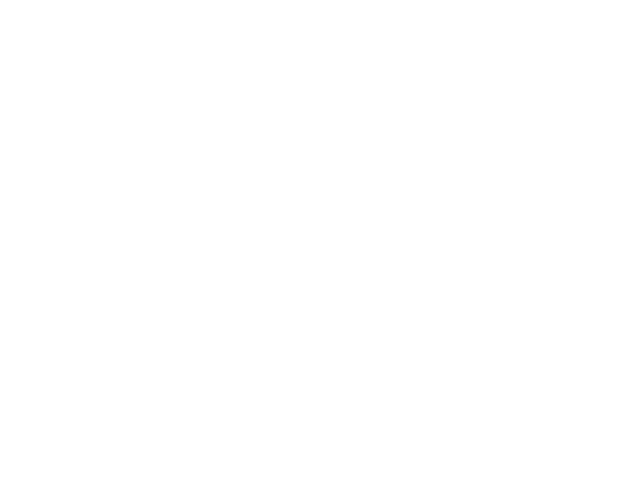

Plotting Image  2


<IPython.core.display.Javascript object>


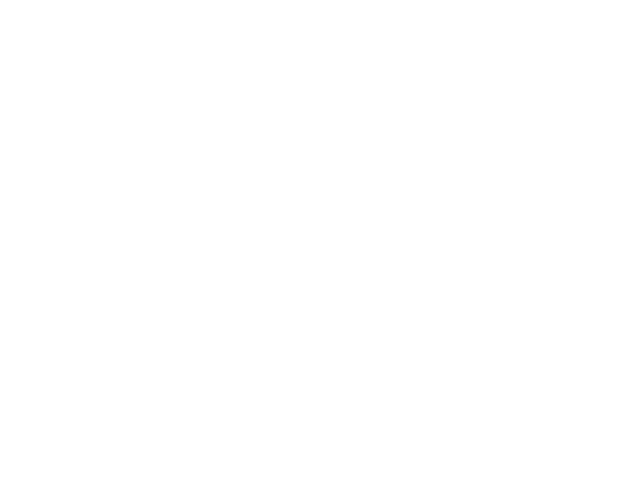

Plotting Image  3


<IPython.core.display.Javascript object>


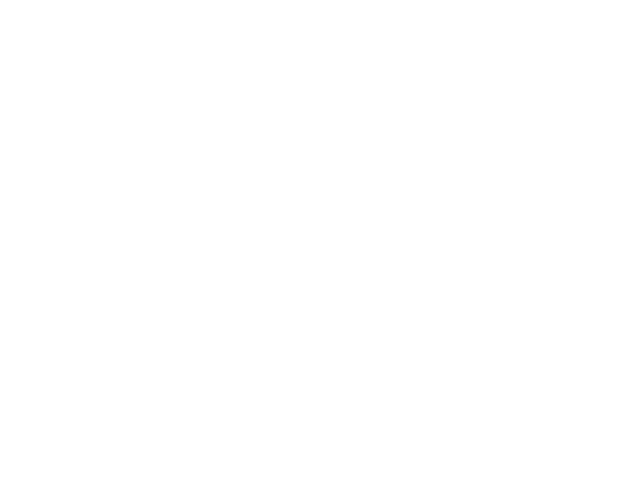

Plotting Image  4


<IPython.core.display.Javascript object>


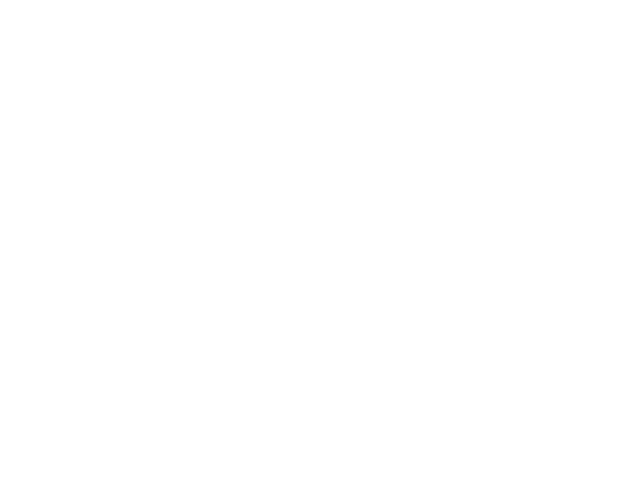

Plotting Image  5


<IPython.core.display.Javascript object>


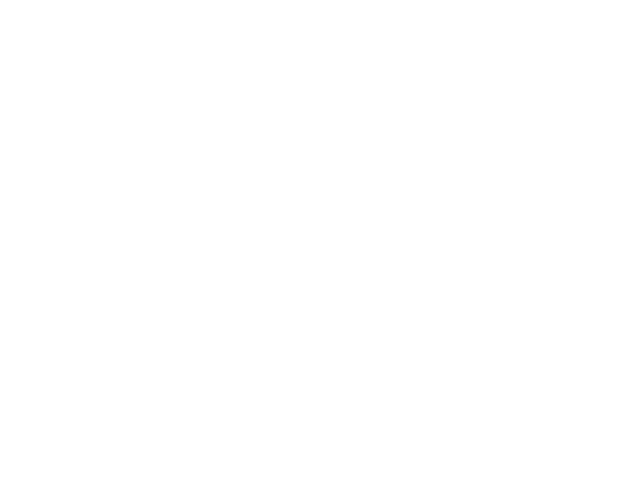

Plotting Image  6


<IPython.core.display.Javascript object>


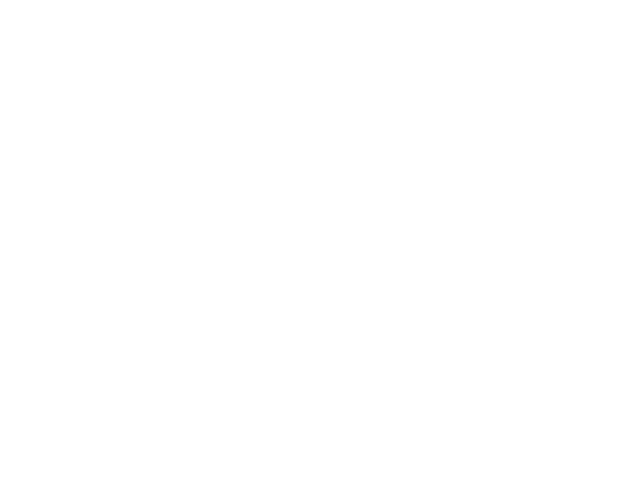

Plotting Image  7


<IPython.core.display.Javascript object>


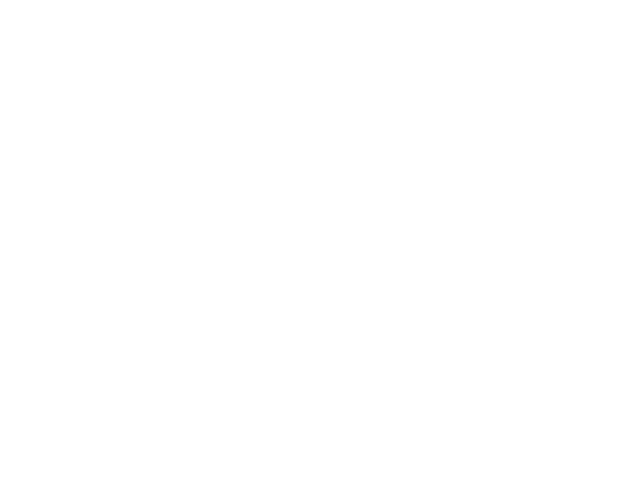

In [10]:
#Visualise the sift points on the 3D box
def sift_plot_3D(idx,kp_3d_all_images):
    if not os.path.exists('sol_1b/3d_sift/image'+str(idx)):
        os.makedirs('sol_1b/3d_sift/image'+str(idx))
    
    
    fig = plt.figure()
    #plt.ion()
    plotarg = np.load('data/plotarg.npz')
    poly3d = plotarg['poly3d']
    #plt.draw()
    ax = plt.axes(projection="3d")
    world_origin = np.array((0, 0, 0)).reshape(3, 1).astype(np.int)
    ax.set_xlim(-0.01,0.2)
    ax.set_ylim(-0.01,0.2)
    ax.set_zlim(-0.01,0.2)
    plt.axis('off')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.dist=15
    ax.scatter3D(0,0,0,c="limegreen",marker="o",s=25)
    plt.show()
    
    ax.add_collection3d(Poly3DCollection(poly3d,facecolors='w',edgecolor='b',linewidths=0.5,alpha=0.0))
    
    kp_3d_image=kp_3d_all_images[ii]
    for i_point in kp_3d_image: 
        ax.scatter3D(i_point[0],i_point[1],i_point[2],c="r",marker=".",s=2)
    
    
    for ang in range(0,360,45):
        ax.view_init(elev=25, azim=270+ang)
        image_name="sol_1b/3d_sift/image"+str(idx)+"/view"+str(ang)+".png"
        #print(image_name)
        plt.savefig(image_name)   
    plt.close('all')
 

for ii in range(8):
    print("Plotting Image ",ii)
    sift_plot_3D(ii,kp_3d_all_images)

In [11]:
#Save the solution values for the next task

b1_list=[]
#b1_list.append(kp_all_images)
b1_list.append(kp_point_all_images)
b1_list.append(kp_rescaled_all_images)
b1_list.append(kp_3d_all_images)
b1_list.append(des_all_images)

import pickle
with open('data/sol_1b.pkl', 'wb') as f:
    pickle.dump(b1_list, f)